## Continnum substraction (亂拼)
應該是**連續譜的 fitting**

因為我的 cube 看起來（也確實是）沒減過連續譜的樣子  
這樣算比值絕對會出問題的吧啊！  
所以要先做這個  

- method ref :  
[micappe] https://github.com/micappe/ppxf_examples ppxf_example_kinematics_sdss.ipynb

- IFU from :  
ESO Arcnive   
Instrument          : VLT MUSE(single)  
Object              : Circinus  
Range(air $\lambda$): 4759-9320 Å（補藥換成頻率啊）      
pID                 : 094.B-0321

In [103]:
# modular
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from ppxf.ppxf import ppxf
from ppxf.ppxf_util import log_rebin
import ppxf.ppxf_util as util
import ppxf.sps_util as lib 

### Setup MUSE data
因為和老哥用的不是同一個儀器的數據  
所以我在這邊要死要活的

In [104]:
# 
c = 299792.458  # [km/s]
z = 0.001448 # circinus galaxy
commonPath = '/Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/'
file_path = f"{commonPath}MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits" # FITS

# metadata
muse_hdul = fits.open(file_path)
muse_hdul.info() # DATA:cube, STAT:noise?
muse_data = muse_hdul['DATA'].data # (RA, DEC, AWAV)
muse_header = muse_hdul['DATA'].header

muse_stat = muse_hdul['STAT'] # 不知道這是什麼
print(muse_stat)

Filename: /Users/aqing/Documents/1004/Circinus_galaxy/ionized-gas/VLT/MUSE_PID-094.B-0321_cube_4750-9352a_circinus.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1341   ()      
  1  DATA          1 ImageHDU        43   (317, 319, 3682)   float32   
  2  STAT          1 ImageHDU        43   (317, 319, 3682)   float32   


#### Make WL & spec axis
 製作波長軸以及光譜軸  

In [105]:
# original AWV axis
crval3 = muse_header['CRVAL3']
cdelt3 = muse_header['CD3_3']
crpix3 = muse_header['CRPIX3']
naxis3 = muse_header['NAXIS3']
ori_lamb = crval3 + (np.arange(naxis3) + 1 - crpix3) * cdelt3 # [AA] in air

# original spectrum intensity axis (flux)
print(f"Original WAV axis's shape = {ori_lamb.shape}")
i, j = muse_data.shape[1]//2, muse_data.shape[2]//2 # certain pixel, 之後應該是要 gothrogh 的
ori_flux_unnorm = muse_data[:, i, j]
if ori_flux_unnorm.shape==ori_lamb.shape : # 他媽的這本來就要一樣吧
    print('Nice ^_-!')

Original WAV axis's shape = (3682,)
Nice ^_-!


#### Futher processing of that two axis
- 對數、真空和air  
- 正規化、考慮噪音

noise 是亂設的

Velocity resolu(?) on ln-WAV axis = 55.17 (km/s)



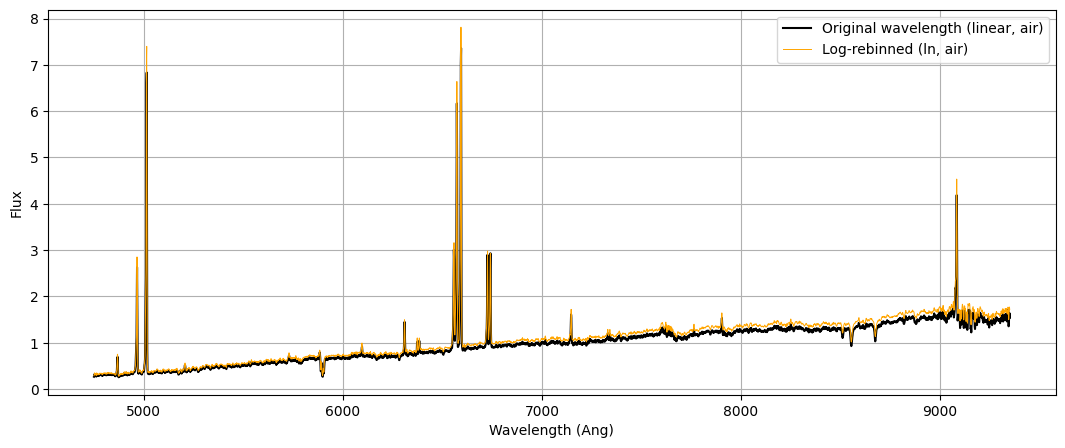

In [106]:
### Log(ln) waveLen array
ln_flux_unnorm, ln_lamb_pix, veloScale = log_rebin([ori_lamb[0], ori_lamb[-1]], ori_flux_unnorm)
print(f"Velocity resolu(?) on ln-WAV axis = {veloScale:.2f} (km/s)", end='\n\n') # veloScale 算好了喔好方便捏
ln_lamb = np.exp(ln_lamb_pix) # 從 ln(lambda) 換成 AA

### flux normalization
def flux_Norm(flux): # 除到 nan 的話，就會爆炸，所以做了這個
    flux_no_nan = flux[~np.isnan(flux)]
    if len(flux_no_nan) > 10 and np.nanmedian(flux_no_nan) != 0:
        return flux / np.nanmedian(flux_no_nan), flux_no_nan
    else:
        return flux

ln_flux, normFactor = flux_Norm(ln_flux_unnorm) # 沒標 un- 就是正規化了
ori_flux, _ = flux_Norm(ori_flux_unnorm) # 等下畫圖的時候用一下而已

### consider noise
noise = np.full_like(ln_flux, 0.0149) # 隨便設一個數字...

### (waveLen) air --> vaccum
# The SDSS wavelengths are in vacuum, while the MILES ones are in air.(micappe 老哥)
# 所以我不用做這個

# 畫出來看看
plt.figure(figsize=(13, 5))
plt.plot(ori_lamb, ori_flux, c='k', label='Original wavelength (linear, air)')
plt.plot(ln_lamb, ln_flux, c='orange', lw=0.7, label='Log-rebinned (ln, air)', linestyle='-') # 大便般的配色
plt.xlabel("Wavelength (Ang)")
plt.ylabel("Flux")
plt.legend()
plt.grid()
plt.show()


#### Check array quality
檢查下等下要拿去算的東西裡面有沒有 NaN, infinite

In [107]:
print('Bad value in ln_flux: ', end='')
print(f'{np.isnan(ln_flux).sum()} NaN, {np.isinf(ln_flux).sum()} inf') #1 NaN
ln_flux_clean = np.copy(ln_flux)
ln_flux_clean[~np.isfinite(ln_flux_clean)] = 0

print('Bad value in noise: ', end='')
print(f'{np.isnan(noise).sum()} NaN, {np.isinf(noise).sum()} inf') # 0, 0

Bad value in ln_flux: 1 NaN, 0 inf
Bad value in noise: 0 NaN, 0 inf


#### something else

fwhm(2.5 AA) 是亂設的

In [108]:
dlam = np.gradient(ln_lamb)          # how many AA is a pixel (like CD3_3, but CD3_3 is for liner sampling)
fwhm = np.full(3682, 2.5)            # [AA] #### 先隨便設了，要放成一長串的
                                     # Resolution FWHM of every pixel, in Angstroms
# r-shift
ln_lamb = ln_lamb / (1+z)
fwhm = fwhm / (1+z)

### Setup stellar templates

In [110]:
temp_path = f'{commonPath}fitting_stellar-continnum/spectra_emiles_9.0.npz' # 從老哥的 github 抓下來的東西
tempRange_lamb = [4500, 9500] # 是出來這樣最好，反正有覆蓋到就好哩
fwhmD = {"lam": ln_lamb, "fwhm": fwhm} # 字典 for 因為不同波長可能對應不同解析度（儀器），但現在找不到資料所以都給他設成一樣的 fwhm

#print(type(ln_lamb), ln_lamb.dtype)
sps = lib.sps_lib(temp_path, veloScale, fwhmD, lam_range=tempRange_lamb) # 讀模型
goodpixs = util.determine_goodpixels(np.log(ln_lamb), tempRange_lamb) # 找出沒污染之類的 pix，備料
# 超好笑有個瓠瓜昨天三十分鐘抓不出一個蟲
# 果然人要先吃飽再做事...
# 而且這邊很好笑，要 run all 才不會報 sps 那行的錯
print(goodpixs) # 和老哥的長差不多，好呢

[   0    1    2 ... 3679 3680 3681]


### FITTING
終於可以 fe 了嗎，感覺等下一定會大報錯啦舉辦

---

**超級加粗**  
**啊啊啊啊啊啊啊做出來了！雖然很多參數是提姆亂射的蛋就是今天先，這個，嗚嗚**

---

**問題：**  
為什麼他強度是從 -1 開始啊？
>但是我自己畫的畫就還好欸，見 Product
>而且 chi2_reduce 也太巨
>para 需要改進的地方請見 github

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       405      1000     0.292     0.300
chi2/DOF: 55.68; DOF: 3462; degree = 20; mdegree = 0
method = capfit; Jac calls: 18; Func calls: 92; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/150


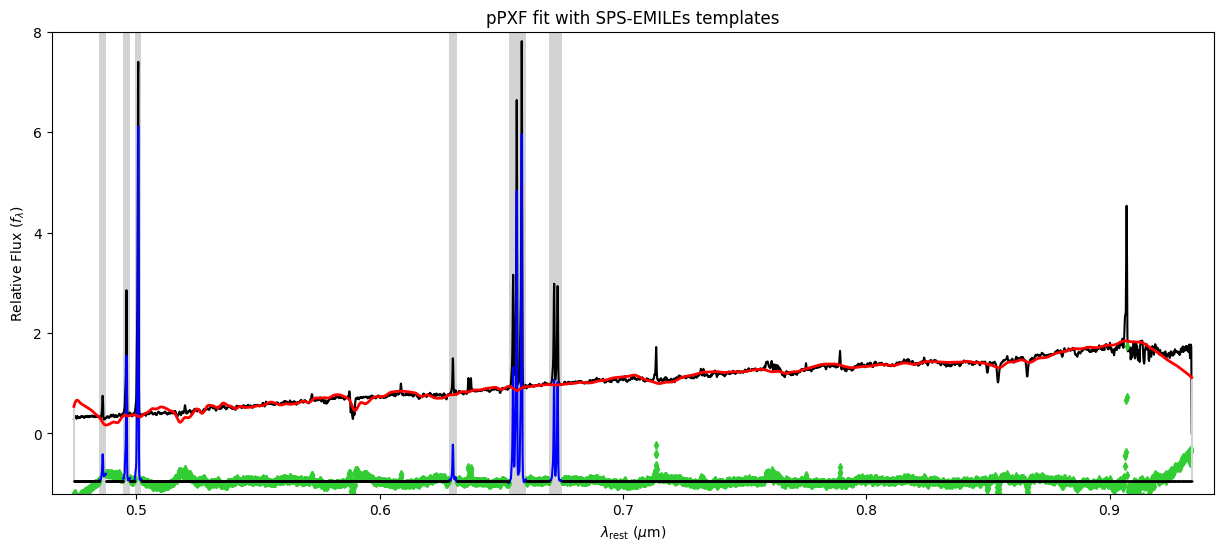

In [ ]:
# fitting
vel = 0                 # Spectrum is de-redshifted --> starting guess is zero
start = [vel, 200.]     # (km/s), starting guess for [V, sigma] # 不知道為什ㄕㄜ這個

feee = ppxf(sps.templates, ln_flux_clean, noise, veloScale, start,
          goodpixels=goodpixs, plot=False,
          moments=4, # (vel, sigma, h3, h3)
          trig=1, # poly-smooth?
          degree=20, # fit 的次數（因為光譜扭來扭去，所以設這麼高是可以的？）
          lam=ln_lamb, lam_temp=sps.lam_temp)

plt.figure(figsize=(15, 6))
feee.plot() # 自帶的秀出來的效果嗚呼
plt.ylim(-1.2, 8)
plt.title(f"pPXF fit with SPS-EMILEs templates")
plt.pause(5)

### Product
謝謝老哥，我將會自己做一些末端的調整  
##
**問題：**  
- 欸啊他全部都往一邊偏是怎樣  
一定是對數軸換來換去的時候那樣那樣了辣！

>最一開始那張黑橘色的圖就有 ln/ori 小偏的情況  
>ㄜ我之後會再修理他，如果他重要的話  
>(偷懶地想說 算強度的話 應該不用說譜線對的很準...)

- 論文裡面有幾條線我沒標，為什麼不標，因為我找不到啊  
6000, 6500 那附近  
>但是應該不影響擬合，因為擬合的過程中並沒有要我輸入發射譜線，  
>或是要 mask 掉他們的情況

In [ ]:
# emission line profile
emission_lines = [('H-beta*', (1+z)*4861), # (line_name, shifted_wave_lenght [Ang])
                  ('O[III]_4958', (1+z)*4958), 
                  ('O[III]_5007*', (1+z)*5007),
                  ('H-alpha*', (1+z)*6562),
                  ('N[II]_6548', (1+z)*6548),
                  ('N[II]_6583*', (1+z)*6583),
                  ('O[I]', (1+z)*6300),
                  #('Ar[III]', (1+z)*7135),
                  ('S[II]_6716', (1+z)*6716),
                  ('S[II]_6730', (1+z)*6730)]

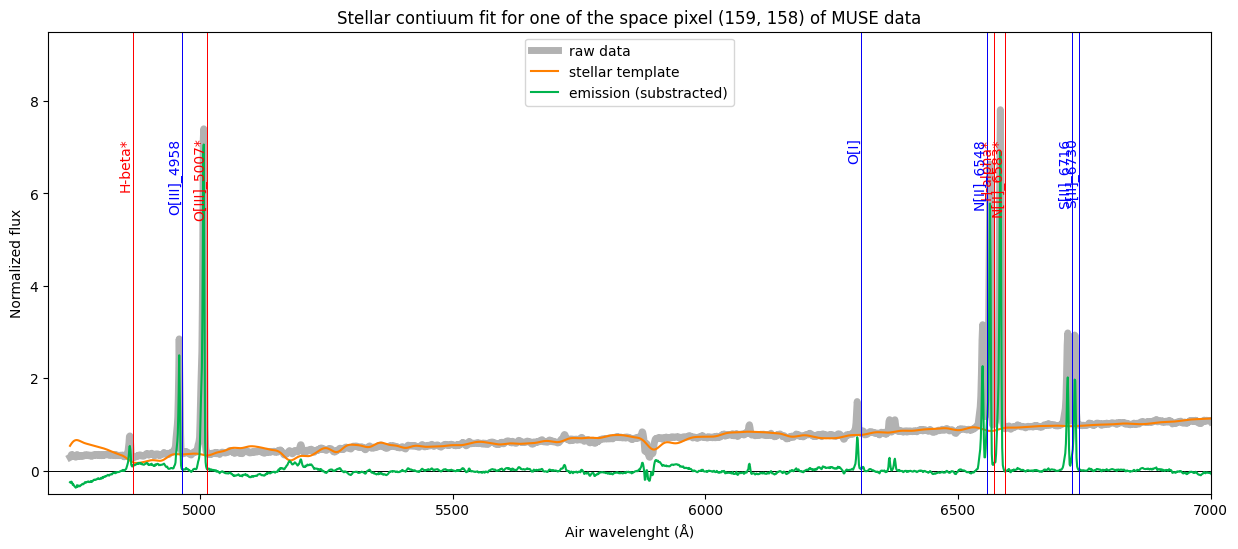

In [ ]:
# fitting result
stellar_flux_conti_norm = feee.bestfit # fit 出來的恆星（連續）譜
                                       # 連續，並且是正規化後的產物
emission_flux_norm = ln_flux_clean - feee.bestfit # 不是 emission_line 了

plt.figure(figsize=(15, 6))
plt.xlim(4700, 7000) # 反正沒旁邊東西
                     # 欸而且切過之後感覺還行耶？
plt.ylim(-0.5, 9.5)
plt.axhline(0, c='k', linestyle='-', lw=0.7)

plt.plot(ln_lamb, ln_flux_clean, c='k', lw=5, alpha=0.3, label='raw data')
plt.plot(ln_lamb, stellar_flux_conti_norm, c=(1,0.5,0), label='stellar template')
plt.plot(ln_lamb, emission_flux_norm, c=(0,0.7,0.3), label='emission (substracted)')
plt.xlabel('Air wavelenght (Å)')
plt.ylabel('Normalized flux')
plt.title(f'Stellar contiuum fit for one of the space pixel ({i}, {j}) of MUSE data')

# emission lines
#'''
for n, l in emission_lines :
    plt.axvline(l, color='r', linestyle="-", lw=0.7)
    if  '*' in n :
        c='r'
    else :
        c='b'
    plt.axvline(l, color=c, linestyle="-", lw=0.7)
    plt.text(l, 8*0.9, n, rotation=90, color=c, fontsize=10, ha='right', va='top')
#'''

plt.legend(loc='upper center')


In [ ]:
# de-nor
'''
#print("Median value used for rescaling:", np.median(ln_flux_unnorm))
# 喔幹又來了
# 所以我應該去老遠之前把正規化因子存下來
# 有點長度不統一，頭痛捏
'''
stellar_flux = stellar_flux_conti_norm * normFactor

emission_flux = emission_flux_norm * normFactor


plt.figure(figsize=(15, 6))
plt.xlim(4700, 7000)
#plt.ylim()
plt.axhline(0, c='k', linestyle='-', lw=0.7)

#plt.plot(ln_lamb, ln_flux_unnorm, c='k', lw=5, alpha=0.3, label='raw data')
plt.plot(ln_lamb, stellar_flux, c=(1,0.5,0), label='stellar template')
plt.plot(ln_lamb, emission_flux, c=(0,0.7,0.3), label='emission (substracted)')
plt.xlabel('Air wavelenght (Å)')
plt.ylabel(r"Flux density ($10^{-20}$ erg/s/cm$^2$/Å)")
plt.title(f'Stellar contiuum fit for one of the space pixel ({i}, {j}) of MUSE data')

ValueError: operands could not be broadcast together with shapes (3682,) (3681,) 